In [17]:
"""
跟着cs231n官方教程学knn
完成knn的三个任务代码编写：
1.实现knn分类器：训练与预测
2.进行测试
3.k值的交叉验证
""" 
import numpy as np
import matplotlib.pyplot as plt
from utils.data_utils import *
import random


# 这是一个让 matplotlib 图形在笔记本中内嵌显示的小技巧
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置默认窗口大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 自动加载你导入的python模块，保证你每次在ipynb里使用的模块是最新版本，因为自定模块很有可能会修改
%load_ext autoreload
%autoreload 2

# 数据集文件根路径
ROOT = 'F:\CS213n Note\cs231n_learn_pycharm\cs231n_learn\Assignment_yh/assignment_1\dataset\cifar-10-batches-py'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# 开始进行编写展示cifar10读出数组的形状
# 清除内存中已有的变量
try:
    del X_train_orgin, y_train_orgin
    del X_test_orgin, y_test_orgin
except:
    pass

X_train_origin, y_train_origin, X_test_origin, y_test_origin = load_CIFAR10(ROOT)
# debug1()

#在读取数据的函数中我们已经将数据图像矩阵进行了降维，成为了二维矩阵， 标签矩阵依旧是一维
print(X_train_origin.shape)
print(y_train_origin.shape)
print(X_test_origin.shape)
print(y_test_origin.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


10


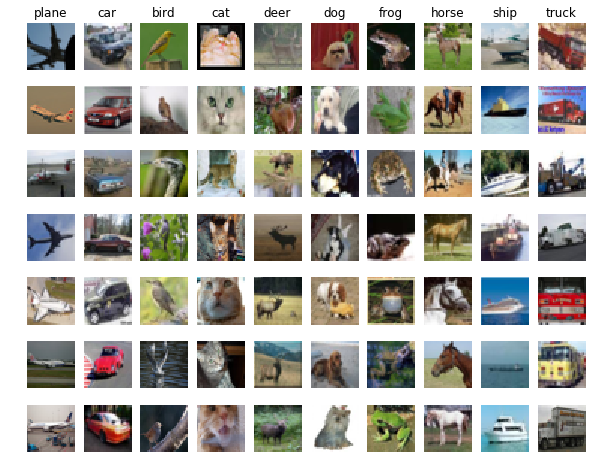

In [19]:
"""
现在进行cifar可视化的编写
"""
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
print(num_classes)
# 设置展示样本的个数，每个类展示7个，这个应该与上面的窗口大小有关
sample_num = 7


"""
先在X_train_origin中选7张，可以使用id代替，让后放置
"""
for y, cls in enumerate(classes):
    # 返回第y类的标签的许多索引
    x_ids = np.flatnonzero(y_train_origin == y)
    # 从中选出7个
    x_ids = np.random.choice(x_ids, sample_num, replace=False)
    for i, x_id in enumerate(x_ids):
        plt_id = i * num_classes + y + 1
        plt.subplot(sample_num, num_classes, plt_id)
        plt.imshow(X_train_origin[x_id].astype(np.uint8))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()
    

In [20]:
# 接下来进行编写knn算法，并进行测试
# 对数据进行简化
trans_num = 5000
test_num = 500

# 进行切片
X_train = X_train_origin[:trans_num]
y_train = y_train_origin[:trans_num]
X_test = X_test_origin[:test_num]
y_test = y_test_origin[:test_num]

# 将图片集拉成1行
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
print(X_test.shape)



(5000, 3072)
(500, 3072)


In [21]:
# 测试KNN
from classifiers.knn_classifier import *

classifier = K_nearest_neighbor_classifier()
# 先训练
classifier.train(X_train, y_train)

In [22]:
# 此时我们得到一个已经被训练过的分类器
# 我们要看一看距离度量的细节

# 测试下两步循环
distances = classifier.computer_distance_by_two_loops(X_test)
print(distances.shape)# test_num * train_num

(500, 5000)


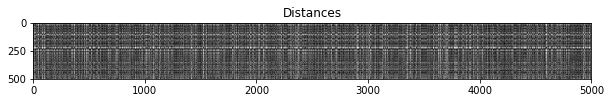

In [23]:
# 可视化距离矩阵,颜色越深距离越近，白色是高距离，黑色是低距离
plt.imshow(distances, interpolation='none')
plt.title("Distances")
plt.show()

In [24]:
# 测试KNN，首先设置k=1，即是最邻近算法,同样默认值就是1,循环数默认值为0
y_pred = classifier.predict(X_test)

# 统计精确度acc
num_correct = np.sum(y_pred == y_test)
acc = float(num_correct) / test_num
print('Got %d / %d correct => accuracy: %f' % (num_correct, test_num, acc))

Got 137 / 500 correct => accuracy: 0.274000


In [25]:
# 设置k=5,表现稍微好一点
y_pred = classifier.predict(X_test, k=5)

# 统计精确度acc
num_correct = np.sum(y_pred == y_test)
acc = float(num_correct) / test_num
print('Got %d / %d correct => accuracy: %f' % (num_correct, test_num, acc))

Got 139 / 500 correct => accuracy: 0.278000


In [26]:
# 现在利用numpy矩阵的广播优势来进行计算效率的提升
distances_1 = classifier.computer_distance_by_one_loops(X_test)

# 验证矢量化的正确性其中最简单的方法是弗罗贝尼斯规范。如果你以前没见过，
# 两个矩阵的 Frobenius norm 是所有元素差值平方和的平方根；换句话说，将矩阵重塑为向量，然后计算它们之间的欧氏距离。
diff = np.linalg.norm(distances - distances_1, ord='fro')
print('difference ==> %f' % (diff))
if diff < 0.001:
    print("计算的距离矩阵相同")
else:
    print("计算的距离矩阵不同")

difference ==> 0.000000
计算的距离矩阵相同


In [27]:
# 再次使用无循环
distances_2 = classifier.computer_distance_by_no_loops(X_test)

# 验证矢量化的正确性其中最简单的方法是弗罗贝尼斯规范。如果你以前没见过，
# 两个矩阵的 Frobenius norm 是所有元素差值平方和的平方根；换句话说，将矩阵重塑为向量，然后计算它们之间的欧氏距离。
diff = np.linalg.norm(distances - distances_2, ord='fro')
print('difference ==> %f' % (diff))
if diff < 0.001:
    print("计算的距离矩阵相同")
else:
    print("计算的距离矩阵不同")

difference ==> 1.594546
计算的距离矩阵不同


In [28]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.computer_distance_by_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.computer_distance_by_one_loops, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.computer_distance_by_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 17.478942 seconds
One loop version took 17.346274 seconds
No loop version took 0.082110 seconds


In [29]:
# 将训练集拿出一部分作为验证集(validation)，超参数的调优,上面我们只拿了5000组来实验
# 我们拿4900组数据作为训练集，100组数据作为验证集，测试集是珍惜资源到最后一刻才可以使用
valid_num = 100
X_valid1 = X_train[:valid_num]
y_valid1 = y_train[:valid_num]
X_train1 = X_train[valid_num:]
y_train1 = y_train[valid_num:]

validation_accs = []
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

for k in k_choices:
    knn = K_nearest_neighbor_classifier()
    knn.train(X_train1, y_train1)
    y_valid_pred = knn.predict(X_valid1, k=k, loops=1)
    num_correct = np.sum(y_valid_pred == y_valid1)
    acc = float(num_correct)/valid_num
    print('k=%d, acc=%f' % (k, acc))
    validation_accs.append(acc)

k=1, acc=0.230000
k=3, acc=0.250000
k=5, acc=0.250000
k=8, acc=0.270000
k=10, acc=0.220000
k=12, acc=0.200000
k=15, acc=0.190000
k=20, acc=0.200000
k=50, acc=0.210000
k=100, acc=0.200000


In [33]:
# 交叉验证找最佳的,分成5份进行交叉验证
# 对数据进行简化
trans_num = 5000
test_num = 100

# 进行切片
X_train = X_train_origin[:trans_num]
y_train = y_train_origin[:trans_num]
X_test = X_test_origin[:test_num]
y_test = y_test_origin[:test_num]

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
print(X_test.shape)

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

# 每组的平均长度
avg_size = int(X_train.shape[0]/num_folds)
for i in range(num_folds):
    X_train_folds.append(X_train[i*avg_size:(i+1)*avg_size])
    y_train_folds.append(y_train[i*avg_size:(i+1)*avg_size])

# 设置k:accs的键值对字典,一个k对应1个精确度列表accs
k_to_accuracies = {}
for k in k_choices:
    accs = []
    for i in range(num_folds):
        # 合并训练集,使用np.vstack与np.hstack
        # np.vstack():按垂直方向（行顺序）堆叠数组构成一个新的数组，用于图像集的合并
        X_train_cv = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
        y_train_cv = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:])
        # 选择验证集    
        X_valid_cv = X_train_folds[i]
        y_valid_cv = y_train_folds[i]
        
        # 进行训练预测
        knn2 = K_nearest_neighbor_classifier()
        knn2.train(X_train_cv, y_train_cv)
        y_valid_pred2 = knn2.predict(X_valid_cv, k=k)
        num_correct = np.sum(y_valid_pred2 == y_valid_cv)
        acc = float(num_correct)/y_valid_cv.shape[0]
        accs.append(acc)
    k_to_accuracies[k] = accs


for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

(5000, 3072)
(100, 3072)
k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accurac

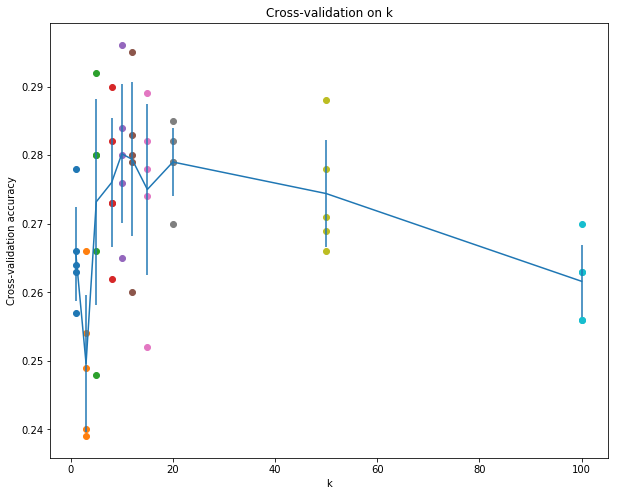

In [36]:
# 可视化交叉验证的内容，需要绘制散点图
for k in k_choices:
    accs = k_to_accuracies[k]
    plt.scatter([k]*len(accs), accs)

# 绘制偏差平均值
# 求每个k对应的算术平均值
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
# 求每个k对应的标准差
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
# 显示一定置信区间的带误差数据
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [35]:
best_k = 1

classifier = K_nearest_neighbor_classifier()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / test_num
print('Got %d / %d correct => accuracy: %f' % (num_correct, test_num, accuracy))

Got 29 / 100 correct => accuracy: 0.290000
